# 確率過程のシミュレーション

## システム

Klein (2000) の方法を使うと, 合理的期待モデルから線形システム

\begin{align}
  x^1_{t+1} &= \Omega_x x_t^1 + \Omega_u u_t + \Omega_y y^u_{t+1} + \xi_{t+1} \\
  x^2_t &= \Psi_x x_t^1 + \Psi_y y^u_t
\end{align}

を導出できる. [16ED07](http://www.kenjisato.jp/teaching/16ED07.pdf) を参照. 有限長の $u$ に対するシミュレーションであればこの表現を用いて分析ができる.

有限でない $u$ に対するシミュレーションを行う場合には, $u_{t+1} = \Phi u_t + \epsilon_{t+1}$ と特定化するのが便利である. 次の状態空間方程式を得る. 

\begin{align*}
&\begin{array}{rcl}
  x_{t+1} &=& 
      \Omega_{x}x_{t} +(\Omega_{u}+\Omega_{y}M\Phi)u_{t}+\xi_{t+1}\\
  y_t &=&
      \Psi_{x}x_{t}+\Psi_{y}Mu_{t}. 
\end{array}& (\Sigma)
\end{align*}

$x_t := x^1_t$, $y_t := x^2_t$ と定義しなおした.　ただし, $M$ はシルベスタ方程式 $M-T_{uu}^{-1}S_{uu}M\Phi=-T_{uu}^{-1}C_{u}$ の解である. 

簡単化のため $\xi_t = 0$ として (Blanchard-Kahn の仮定), 線形確率システム $(\Sigma)$ のシミュレーションをしてみよう. 

\begin{align*}
  u_0 &= 0.01 \\
  \Phi &= 0.5
\end{align*}

とし, $\epsilon_{t+1}$ は $[0,0.001]$ 上の一様分布に従う iid 確率過程とする. 

まずは利用するライブラリをインポートする. 

In [59]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import scipy.stats as st
import matplotlib.pyplot as plt

%matplotlib inline 
# Jupyter Notebook で図をノート内に表示

前回のデータを再利用する. 

In [45]:
with np.load('coeff.npz') as data:
    Omega_x = data['Omega_x']
    Omega_y = data['Omega_y']
    Omega_u = data['Omega_u']
    Psi_x = data['Psi_x']
    Psi_y = data['Psi_y']
    Tuu = data['Tuu']
    Suu = data['Suu']
    Cu = data['Cu']

### $u$ のシミュレーション

#### 一様乱数

今回は, シミュレーションに[ジェネレータ](https://wiki.python.org/moin/Generators)を用いよう. 入力項の生成も逐次的に行う.  

In [69]:
def u_gen(u0, phi, e):
    u0 = u0
    while True:
        u1 = phi * u0 + e.rvs()
        yield u0
        u0 = u1

In [70]:
u = u_gen(u0=0.01, phi=Phi, e=st.uniform(0.0, 0.001))
for _ in range(10):
    print(next(u))

0.01
0.005169861450748102
0.0033274107570820284
0.002081344292774301
0.0018124505949755779
0.0017938487837836428
0.001144300115294939
0.0008574199564308066
0.0005207940931101046
0.001039040216613581


システム $(\Sigma)$ のシミュレーションコードは次のように書ける. `scipy.linalg.solve_sylvester` でシルベスタ方程式を解いている.

In [123]:
def gen_path(x0, u0, phi, e):
    x0 = np.asarray(x0).reshape((2,1))
    M = la.solve_sylvester(-la.solve(Tuu,Suu), 
                           np.array([[1/phi]]), 
                           -la.solve(Tuu, Cu)/phi)
    u = u_gen(u0, phi, e)
    
    while True:
        u0 = next(u)
        x1 = (Omega_x.dot(x0) +
              (Omega_u + Omega_y.dot(M) * phi) * u0)
        y0 = Psi_x.dot(x0) + Psi_y.dot(M) * u0
        
        yield (x0, y0)
        
        x0 = x1

シミュレーション結果は `for t in range(steps)` という標準的なループを用いれば取り出せる. `next` 関数を使わずに書くと次のように書ける. 

In [137]:
k, z, n, c = [], [], [], []

path = gen_path(x0=[0.0, 0.0], u0=0.01, 
                phi=0.5, e=st.uniform(0.0, 0.001))

for (x, y), _ in zip(path, range(200)):
    k.append(x[0, 0])
    z.append(x[1, 0])
    n.append(y[0, 0])
    c.append(y[1, 0])

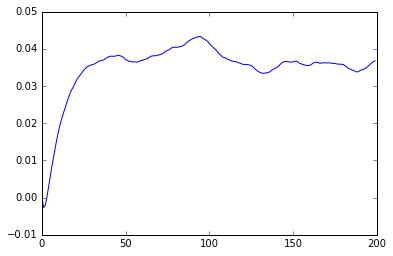

In [138]:
plt.plot(k)

決定論的定常状態: 

In [139]:
cb, kb = (0.5511920622464518, 2.772987427012156)
nb, zb = (0.29583592293349903, 1.)

シミュレーション結果を繰り返し出力できるように, 関数として抽象化しよう.

In [143]:
def simulate(x0, u0, phi, e, steps):
    """simulate Hansen's RBC model
    
    Parameters
    ----------
    
    x0: 2d array of float
        Initial values for K and Z, typically x0 = [0., 0.]
        
    u0: float
        Initial value for u
        
    phi: float
        u1 = phi * u0 + e
        
    e: (distribution object with
        attribute method rvs)
        
    steps: int
        length of simulation    
    
    """
  
    k, z, n, c = [], [], [], []

    path = gen_path(x0, u0, phi, e)
    for (x, y), t in zip(path, range(steps)):
        k.append(x[0, 0])
        z.append(x[1, 0])
        n.append(y[0, 0])
        c.append(y[1, 0])

    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(10,8)


    ax[0, 0].set_title('$K$')
    ax[0, 0].plot(kb + kb*np.array(k))
    ax[0, 0].axhline(kb, color='black', linestyle='dotted')

    ax[0, 1].set_title('$Z$')
    ax[0, 1].plot(zb + zb*np.array(z))
    ax[0, 1].axhline(zb, color='black', linestyle='dotted')

    ax[1, 0].set_title('$N$')
    ax[1, 0].plot(nb + nb*np.array(n))
    ax[1, 0].axhline(nb, color='black', linestyle='dotted')

    ax[1, 1].set_title('$C$')
    ax[1, 1].plot(cb + cb*np.array(c))
    ax[1, 1].axhline(cb, color='black', linestyle='dotted')

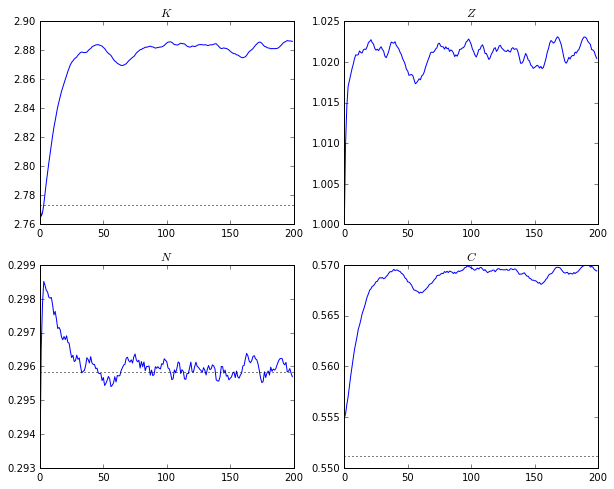

In [144]:
simulate(x0=[0.0, 0.0], u0=0.01, 
         phi=0.5, e=st.uniform(0.0, 0.001), steps=200)

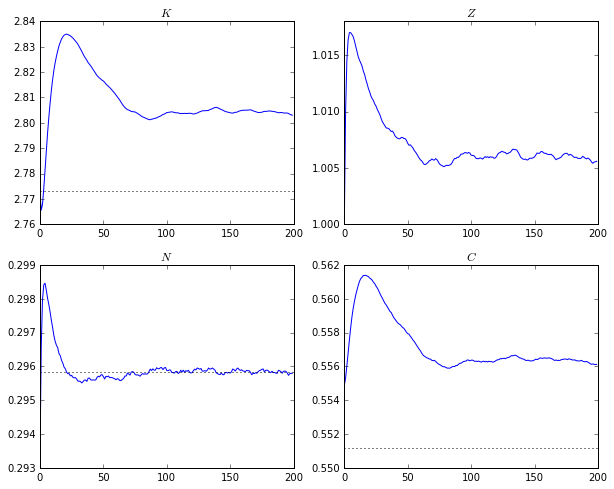

In [136]:
simulate(x0=[0.0, 0.0], u0=0.01, 
         phi=0.5, e=st.uniform(0.0, 0.0003), steps=200)